In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy import stats

In [41]:
df = pd.read_csv(r'C:\Users\hp\Downloads\archive (4)\Advertising.csv')
df

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


In [43]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


,Unnamed: 0,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [45]:
print("missing values: ",df.isnull().sum())
print("Dublicated values : ",df.columns.duplicated().sum())

missing values:  Unnamed: 0    0
TV            0
Radio         0
Newspaper     0
Sales         0
dtype: int64
Dublicated values :  0


In [47]:
print(df.columns.tolist())

['Unnamed: 0', 'TV', 'Radio', 'Newspaper', 'Sales']


In [49]:
print("\nData types:\n", df.dtypes)
df = df.drop('Unnamed: 0', axis=1)


Data types:
 Unnamed: 0      int64
TV            float64
Radio         float64
Newspaper     float64
Sales         float64
dtype: object


In [53]:
# Calculate IQR for Newspaper
Q1 = df['Newspaper'].quantile(0.25)  # ~20 (from boxplot)
Q3 = df['Newspaper'].quantile(0.75)  # ~80 (from boxplot)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Newspaper Outlier Thresholds:")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Max observed: {df['Newspaper'].max()}")

Newspaper Outlier Thresholds:
Lower bound: -35.78
Upper bound: 93.62
Max observed: 93.625


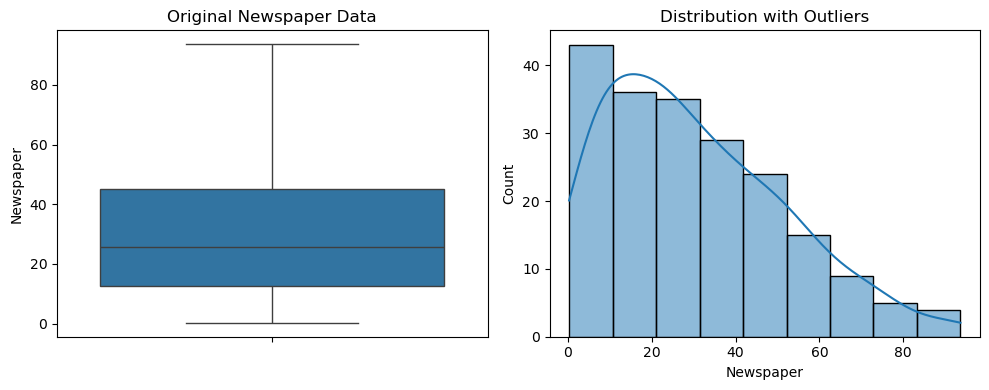

In [55]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Newspaper'])
plt.title('Original Newspaper Data')

plt.subplot(1, 2, 2)
sns.histplot(df['Newspaper'], kde=True)
plt.title('Distribution with Outliers')
plt.tight_layout()
plt.show()

In [61]:
df['Newspaper_capped'] = np.where(
    df['Newspaper'] > upper_bound,
    upper_bound,
    np.where(
        df['Newspaper'] < lower_bound,
        lower_bound,
        df['Newspaper']
    )
)
df['Newspaper_log'] = np.log1p(df['Newspaper'])  # log(1+x) to handle zeros
df['Newspaper_binned'] = pd.cut(df['Newspaper'],
                               bins=[0, 20, 80, df['Newspaper'].max()],
                               labels=['Low', 'Medium', 'High'])


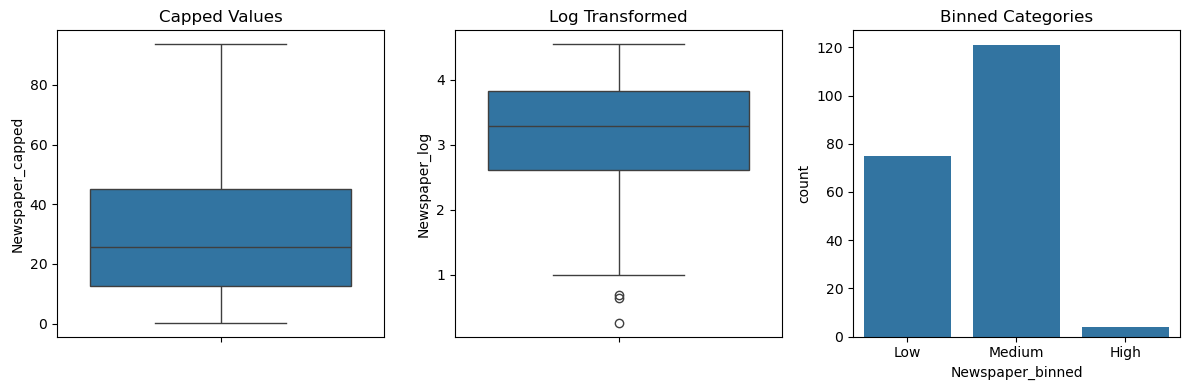

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Newspaper_capped'])
plt.title('Capped Values')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['Newspaper_log'])
plt.title('Log Transformed')

plt.subplot(1, 3, 3)
sns.countplot(x=df['Newspaper_binned'])
plt.title('Binned Categories')
plt.tight_layout()
plt.show()

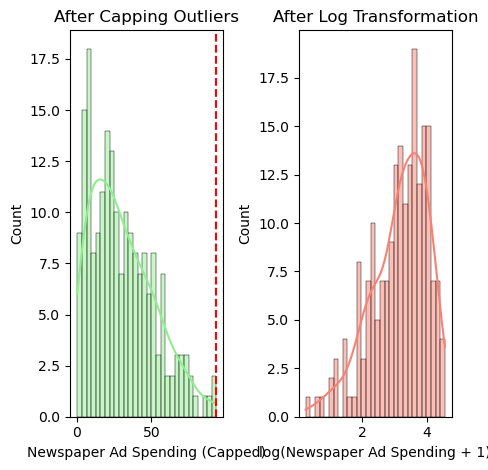

In [65]:
plt.subplot(1, 3, 2)
sns.histplot(df['Newspaper_capped'], kde=True, color='lightgreen', bins=30)
plt.title('After Capping Outliers')
plt.xlabel('Newspaper Ad Spending (Capped)')
plt.axvline(x=upper_bound, color='red', linestyle='--')

# Log-Transformed Data
plt.subplot(1, 3, 3)
sns.histplot(df['Newspaper_log'], kde=True, color='salmon', bins=30)
plt.title('After Log Transformation')
plt.xlabel('log(Newspaper Ad Spending + 1)')

plt.tight_layout()
plt.show()

In [73]:
# 1. Initial Analysis
print("Original Statistics:")
print(f"Skewness: {stats.skew(df['Newspaper']):.2f}")
print(f"Kurtosis: {stats.kurtosis(df['Newspaper']):.2f}")
print(f"95th percentile: {np.percentile(df['Newspaper'], 95):.2f}")

# 2. Outlier Treatment with Percentile Capping
p95 = np.percentile(df['Newspaper'], 95)
df['Newspaper_capped'] = np.where(df['Newspaper'] > p95, p95, df['Newspaper'])

# 3. Power Transformation (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson')
df['Newspaper_power'] = pt.fit_transform(df[['Newspaper_capped']])

# 4. Quantile Transformation
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df['Newspaper_quantile'] = qt.fit_transform(df[['Newspaper_capped']])



Original Statistics:
Skewness: 0.74
Kurtosis: -0.07
95th percentile: 71.82


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(


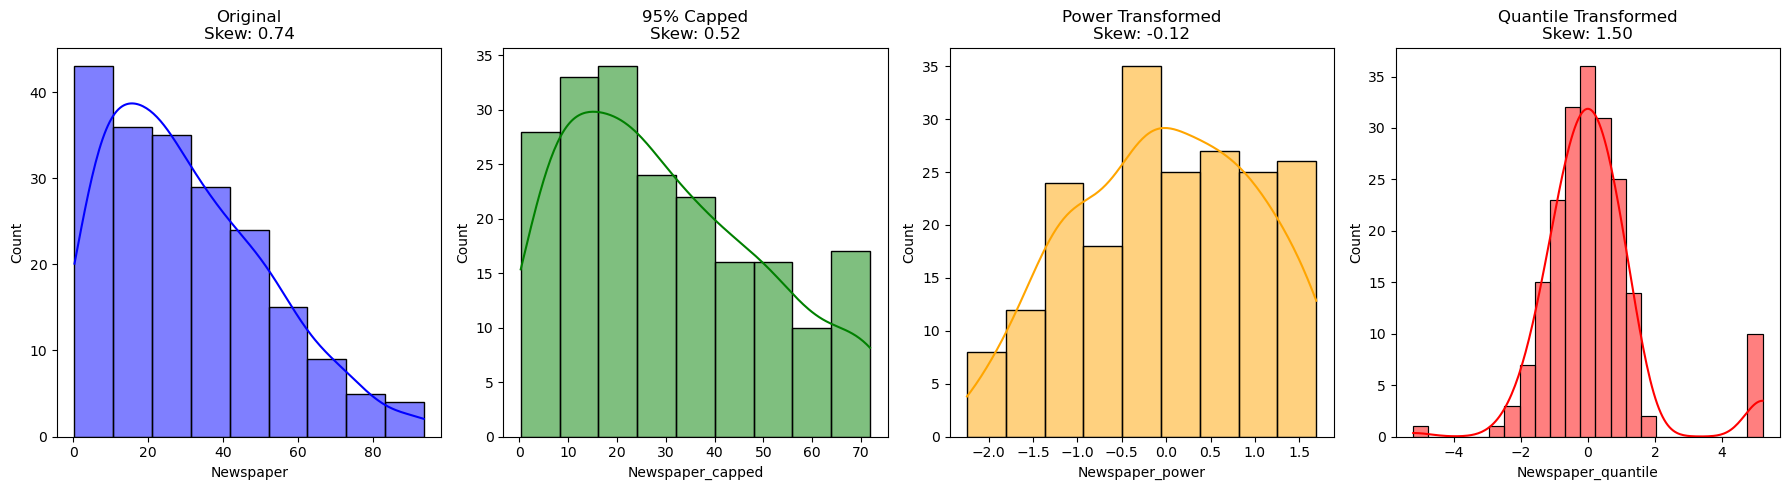

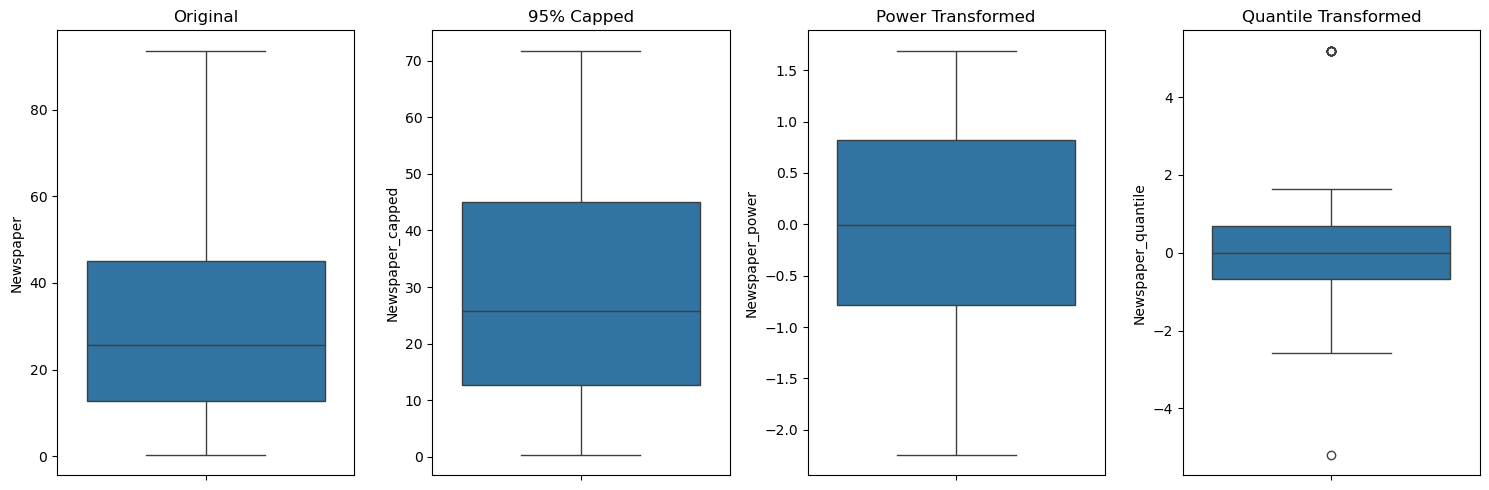


Normality Tests:
Newspaper            p-value: 0.0003 (Non-normal)
Newspaper_capped     p-value: 0.0001 (Non-normal)
Newspaper_power      p-value: 0.0000 (Non-normal)
Newspaper_quantile   p-value: 0.0000 (Non-normal)


In [75]:
# 5. Visual Comparison
plt.figure(figsize=(18, 5))

# Original
plt.subplot(1, 4, 1)
sns.histplot(df['Newspaper'], kde=True, color='blue')
plt.title(f"Original\nSkew: {stats.skew(df['Newspaper']):.2f}")

# Capped
plt.subplot(1, 4, 2)
sns.histplot(df['Newspaper_capped'], kde=True, color='green')
plt.title(f"95% Capped\nSkew: {stats.skew(df['Newspaper_capped']):.2f}")

# Power Transformed
plt.subplot(1, 4, 3)
sns.histplot(df['Newspaper_power'], kde=True, color='orange')
plt.title(f"Power Transformed\nSkew: {stats.skew(df['Newspaper_power']):.2f}")

# Quantile Transformed
plt.subplot(1, 4, 4)
sns.histplot(df['Newspaper_quantile'], kde=True, color='red')
plt.title(f"Quantile Transformed\nSkew: {stats.skew(df['Newspaper_quantile']):.2f}")

plt.tight_layout()
plt.show()

# 6. Boxplot Comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.boxplot(y=df['Newspaper']).set_title('Original')
plt.subplot(1, 4, 2)
sns.boxplot(y=df['Newspaper_capped']).set_title('95% Capped')
plt.subplot(1, 4, 3)
sns.boxplot(y=df['Newspaper_power']).set_title('Power Transformed')
plt.subplot(1, 4, 4)
sns.boxplot(y=df['Newspaper_quantile']).set_title('Quantile Transformed')
plt.tight_layout()
plt.show()

# 7. Normality Tests
print("\nNormality Tests:")
for col in ['Newspaper', 'Newspaper_capped', 'Newspaper_power', 'Newspaper_quantile']:
    stat, p = stats.normaltest(df[col])
    print(f"{col:20} p-value: {p:.4f} ({'Normal' if p > 0.05 else 'Non-normal'})")

In [87]:
# 3. Feature Transformation
pt = PowerTransformer(method='yeo-johnson')
df[['TV', 'Radio', 'Newspaper']] = pt.fit_transform(df[['TV', 'Radio', 'Newspaper']])

In [91]:
# Select only numerical features
numerical_features = ['TV', 'Radio', 'Newspaper']  # Explicitly list numerical columns
X = df[numerical_features]
y = df['Sales']



In [93]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [95]:
# Evaluate
y_pred = model.predict(X_test_scaled)
print(f"\nModel Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2: {r2_score(y_test, y_pred):.2f}")

# Feature importance
coefficients = pd.DataFrame({
    'Feature': numerical_features,
    'Impact': model.coef_
}).sort_values('Impact', ascending=False)

print("\nFeature Importance:")
print(coefficients)


Model Performance:
RMSE: 1.65
R2: 0.91

Feature Importance:
     Feature    Impact
0         TV  3.810614
1      Radio  2.760204
2  Newspaper  0.124892


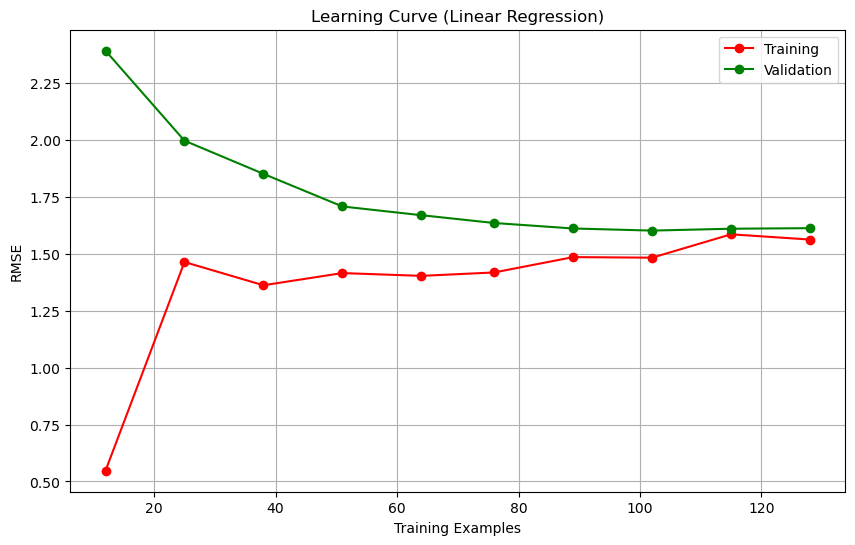

In [97]:
#check the model if there is undefiting or overfitting or not
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Create learning curve visualization
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(), 
    X_train_scaled, 
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Convert to positive RMSE
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")
plt.xlabel("Training Examples")
plt.ylabel("RMSE")
plt.title("Learning Curve (Linear Regression)")
plt.legend()
plt.grid()
plt.show()

In [99]:
# Calculate optimal spend ratios based on coefficients
total_impact = sum(abs(model.coef_))
budget_ratios = [abs(coef)/total_impact for coef in model.coef_]

print("\nOptimal Budget Allocation:")
for feature, ratio in zip(numerical_features, budget_ratios):
    print(f"- {feature}: {ratio*100:.1f}% of budget")


Optimal Budget Allocation:
- TV: 56.9% of budget
- Radio: 41.2% of budget
- Newspaper: 1.9% of budget


In [101]:
# Create realistic scenarios
scenarios = pd.DataFrame({
    'TV': [df['TV'].median(), df['TV'].median()*1.2, df['TV'].median()*0.8],
    'Radio': [df['Radio'].median(), df['Radio'].median()*1.1, df['Radio'].median()*1.1],
    'Newspaper': [df['Newspaper'].median()]*3
})

# Predict outcomes
scenarios_scaled = scaler.transform(scenarios)
scenarios['Predicted_Sales'] = model.predict(scenarios_scaled)
scenarios['ROI'] = scenarios['Predicted_Sales'] / scenarios.sum(axis=1)

print("\nScenario Analysis:")
print(scenarios)


Scenario Analysis:
         TV     Radio  Newspaper  Predicted_Sales       ROI
0  0.121922  0.111978   0.000203        14.807218  0.984436
1  0.146307  0.123176   0.000203        14.933177  0.982261
2  0.097538  0.123176   0.000203        14.743176  0.985237


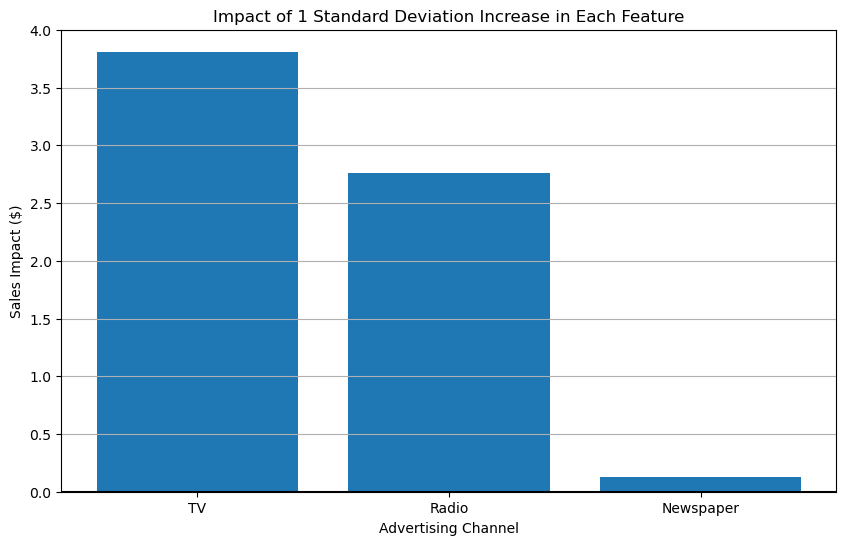

In [103]:
# Visualize feature impacts
plt.figure(figsize=(10,6))
plt.bar(numerical_features, model.coef_)
plt.axhline(y=0, color='k')
plt.title("Impact of 1 Standard Deviation Increase in Each Feature")
plt.ylabel("Sales Impact ($)")
plt.xlabel("Advertising Channel")
plt.grid(axis='y')
plt.show()

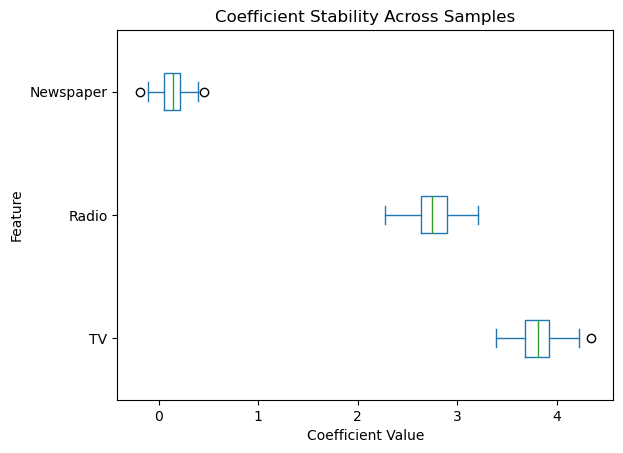

In [105]:
# Check model stability
from sklearn.utils import resample

coefs = []
for _ in range(100):
    X_resampled, y_resampled = resample(X_train_scaled, y_train)
    m = LinearRegression().fit(X_resampled, y_resampled)
    coefs.append(m.coef_)
    
coefs = pd.DataFrame(coefs, columns=numerical_features)
coefs.plot(kind='box', vert=False)
plt.title("Coefficient Stability Across Samples")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()